# HR Attrition Analytics: Exploratory Data Analysis
# 
This notebook documents the exploratory data analysis (EDA) process for the HR Attrition Analytics project. Here, we connect to the HR database, examine employee attrition patterns, and develop visualizations and insights that inform the design of the interactive dashboard.


### Database Connection and Data Import
This section establishes a connection to the MySQL HR database, defines helper functions for executing SQL queries, and loads the employee data into pandas DataFrames for analysis.


In [1]:
# !pip install mysql-connector-python
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_db_connection():
    try:
        db = mysql.connector.connect(
            host="localhost",
            user="root",
            password="*******", #stored in a seperate file
            database="hrdb",
            use_pure=True
        )
        print("Connection successful")
        return db
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

def sql_script(query):
    mycursor.execute(query)
    result = mycursor.fetchall()
    column_names = [i[0] for i in mycursor.description]
    df = pd.DataFrame(result, columns=column_names)

    return df

db = get_db_connection()
mycursor = db.cursor()

table1 = sql_script("SELECT * FROM table1")
table2 = sql_script("SELECT * FROM table2")
attrition_data = table1.merge(table2, on="EmployeeNumber", how="left")
print("Database imported to DataFrame")

Connection successful
Database imported to DataFrame


### Attrition Rate by Department
Looking at the attrition levels in each department, we noticed that the highest attrition rate was in the sales department, despite this department having the highest median salary in the entire company. This lead us to try and further break down the attrition within the sales department.


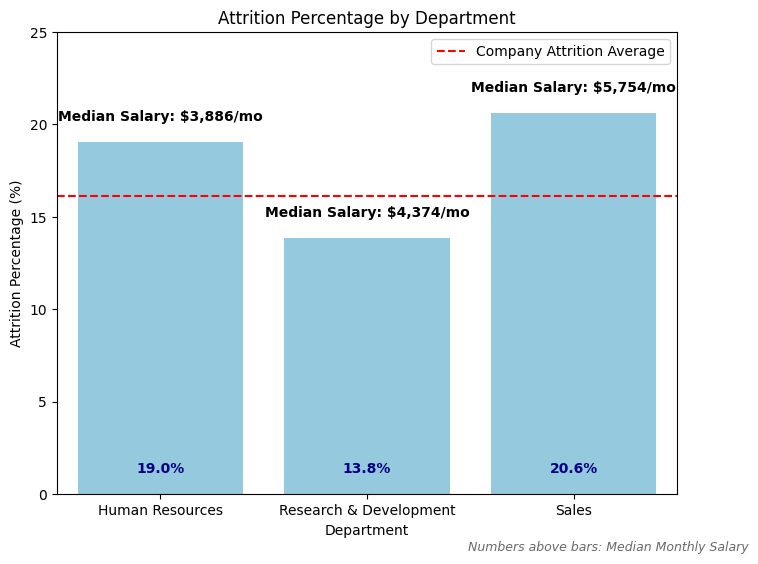

In [10]:
# Calculate overall attrition percentage for the entire company
attr_col = attrition_data['Attrition']
total_attrition = (attr_col == 'Yes').sum() if attr_col.dtype == object else attr_col.sum()
overall_attrition_percentage = total_attrition / len(attrition_data) * 100

# Calculate attrition percentage for each department
attrition_percentage = attrition_data.groupby('Department')['Attrition'].apply(
    lambda x: (x == 'Yes').mean() * 100 if x.dtype == object else x.mean() * 100
).reset_index(name='Attrition_Percentage')

# Median salary for each department (in same order as attrition_percentage)
median_salary_by_dept = attrition_data.groupby('Department')['MonthlyIncome'].median().reindex(attrition_percentage['Department']).values

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=attrition_percentage, x='Department', y='Attrition_Percentage', color='skyblue')
plt.axhline(overall_attrition_percentage, color='red', linestyle='--', label='Company Attrition Average')
plt.title('Attrition Percentage by Department')
plt.ylabel('Attrition Percentage (%)')
plt.xlabel('Department')
plt.ylim(0, 25)  # Changed from 100 to 25 to set scale to 25%
plt.legend()

for i, p in enumerate(ax.patches):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Median salary label above bar
    ax.text(x, y + 1, f"Median Salary: ${median_salary_by_dept[i]:,.0f}/mo",
            ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
    # Attrition rate label at bottom of bar
    ax.text(x, 1, f"{y:.1f}%", ha='center', va='bottom', fontsize=10, color='navy', fontweight='bold')

plt.gcf().text(
    0.99, 0.01,
    "Numbers above bars: Median Monthly Salary",
    fontsize=9, color='dimgray', ha='right', va='bottom', style='italic'
)
plt.show()


### Job Satisfaction Distribution by Attrition (per Department)
The following tables show, for each department, how job satisfaction levels are distributed among employees who stayed versus those who left (attrition). We see that in the sales department, only the most satisfied employees have low attrition rate. We need to understand how to improve job satisfaction within this department


In [14]:
# Print Job Satisfaction distribution by Attrition for each department, formatted as a styled table
from IPython.display import display, HTML

table_htmls = []
for dept in attrition_data['Department'].unique():
    dept_data = attrition_data[attrition_data['Department'] == dept]
    if {'Attrition', 'JobSatisfaction'}.issubset(dept_data.columns):
        styled = (
            pd.crosstab(
                dept_data['JobSatisfaction'],
                dept_data['Attrition'],
                normalize='index'
            ).mul(100).round(2)
            .style.background_gradient(cmap="Blues", axis=None)
            .set_caption(f"<b>Job Satisfaction Distribution in {dept} Department (by Attrition)</b>")
            .format("{:.2f}%")
            .set_table_styles([{
                'selector': 'caption',
                'props': [('color', '#222'), ('font-size', '1.1em'), ('font-weight', 'bold'),
                          ('text-align', 'center'), ('margin-bottom', '10px')]
            }])
        )
        html = styled.to_html().replace('<style type="text/css">', '<style type="text/css" scoped>')
        table_htmls.append(html)
    else:
        table_htmls.append(f"<div><b>Required columns 'Attrition' and/or 'JobSatisfaction' not found in {dept} data.</b></div>")

display(HTML(
    f"""<div style="display: flex; flex-wrap: wrap; gap: 24px; justify-content: center;">
        {''.join(f'<div style="flex:1 1 0; min-width:320px; max-width:400px;">{tbl}</div>' for tbl in table_htmls)}
    </div>"""
))


Attrition,No,Yes
JobSatisfaction,,
1,73.26%,26.74%
2,76.74%,23.26%
3,78.74%,21.26%
4,85.03%,14.97%
Attrition,No,Yes
JobSatisfaction,,
1,80.21%,19.79%
2,86.21%,13.79%
3,85.67%,14.33%


### Attrition Percentage by Job Role in Sales Department
The following chart displays the attrition rate for each job role within the Sales department. This visualization helps identify which sales roles have higher attrition rates, highlighting areas where retention strategies may be needed.
We see that sales representatives show an unusually high attrition rate, so we will need to further investigate this job role.
The findings in this graph are corroborated by studies showing that attrition of sales representative tends to be significantly higher than that of employees in other fields.


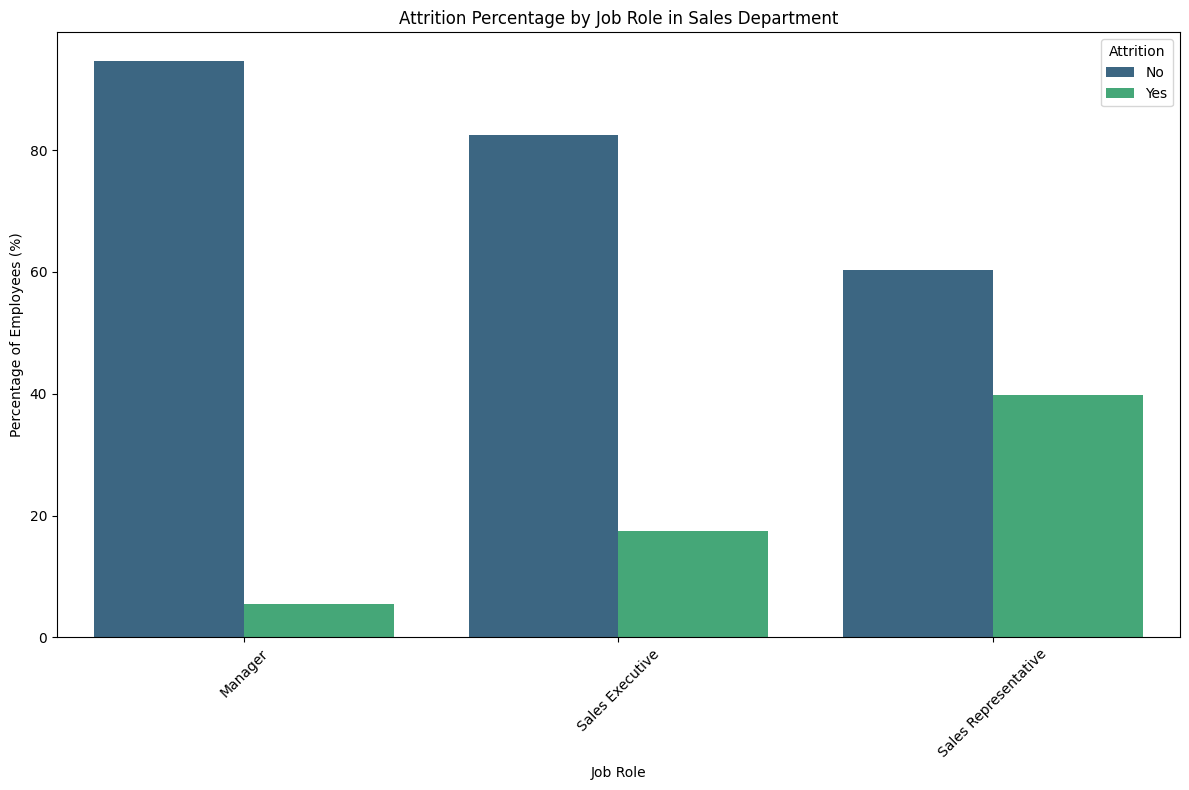

In [15]:
# Show attrition percentage across job roles in the Sales department, and add mean monthly rate for each bar

plt.figure(figsize=(12, 8))
sales_attrition = attrition_data[attrition_data['Department'] == 'Sales']

# Calculate percentage of attrition (Yes/No) within each JobRole and mean MonthlyRate
attrition_counts = (
    sales_attrition
    .groupby(['JobRole', 'Attrition'])
    .agg(Count=('Attrition', 'size'), MeanMonthlyRate=('MonthlyRate', 'mean'))
    .reset_index()
)
attrition_counts['Percentage'] = (
    attrition_counts['Count'] / attrition_counts.groupby('JobRole')['Count'].transform('sum') * 100
)

sns.barplot(
    data=attrition_counts,
    x='JobRole',
    y='Percentage',
    hue='Attrition',
    palette='viridis'
)
plt.title('Attrition Percentage by Job Role in Sales Department')
plt.xlabel('Job Role')
plt.ylabel('Percentage of Employees (%)')
plt.xticks(rotation=45)
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()


### Years at Company Distribution for Sales Representatives
The following chart shows the distribution of years at the company for employees in the "Sales Representative" job role.
We see that in the first two years, attrition rates are extremely high. This is alligned with studies showing that the first two years at a workplace are more prone to attrition.


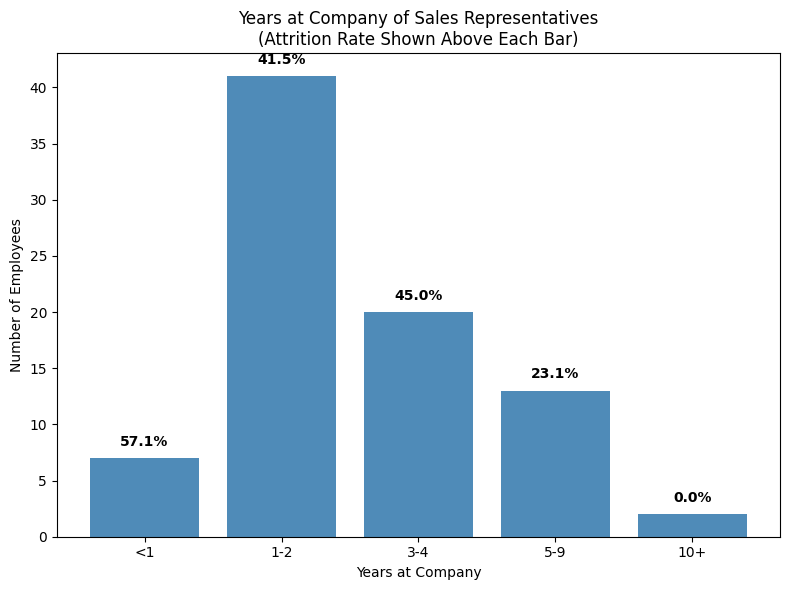

In [27]:
# Years at Company distribution for Sales Representatives with attrition rates as labels

plt.figure(figsize=(8, 6))
sales_reps = attrition_data[attrition_data['JobRole'] == 'Sales Representative'].copy()
bins = sorted({0, 1, 3, 5, 10, sales_reps['YearsAtCompany'].max() + 1})
labels = ['<1', '1-2', '3-4', '5-9', '10+']
sales_reps['YearsAtCompanyGroup'] = pd.cut(sales_reps['YearsAtCompany'], bins=bins, labels=labels, right=False)

years_counts = sales_reps['YearsAtCompanyGroup'].value_counts().sort_index()
attrition_rates = sales_reps.groupby('YearsAtCompanyGroup', observed=False)['Attrition'].apply(lambda x: (x == 'Yes').mean() * 100).sort_index()

bar_color = '#4F8BB8'
plt.bar(years_counts.index.astype(str), years_counts.values, color=bar_color)

for i, label in enumerate(years_counts.index):
    rate = attrition_rates.get(label)
    if pd.notnull(rate):
        plt.text(i, years_counts[label] + years_counts.max() * 0.02, f"{rate:.1f}%", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title('Years at Company of Sales Representatives\n(Attrition Rate Shown Above Each Bar)')
plt.xlabel('Years at Company')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()


### Education Level for Sales Representatives
Sales representatives tend to have relatively low level of education. It seems that these employees are at the start of their careers (also explaining why most of them are only 1-2 years at the company), probably working as sales representatives in parallel to college or university studies.
The challenge is to make these workers, who don't consider their roles as a start of a long term career, to be more inclined to stay at the job.


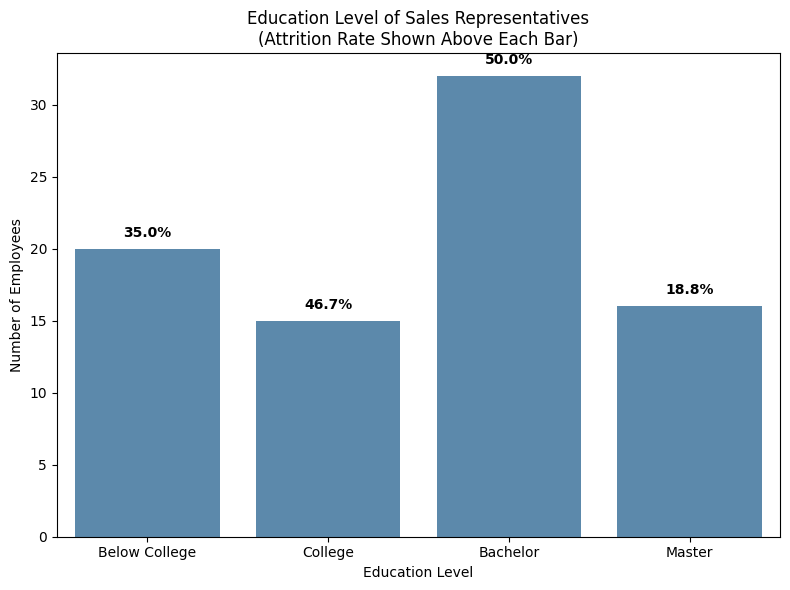

In [35]:
# Show education level distribution for all Sales Representatives, with attrition rates as labels

plt.figure(figsize=(8, 6))
sales_reps = attrition_data[attrition_data['JobRole'] == 'Sales Representative']

education_labels = {
    1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'
}
# Count and attrition rate per education level, mapped to labels
education_counts = sales_reps['Education'].value_counts().sort_index()
attrition_rates = sales_reps.groupby('Education', observed=False)['Attrition'].apply(lambda x: (x == 'Yes').mean() * 100).sort_index()
labels = [education_labels.get(x, str(x)) for x in education_counts.index]

bar_color = '#4F8BB8'
ax = sns.barplot(x=labels, y=education_counts.values, color=bar_color)

for i, (count, rate) in enumerate(zip(education_counts.values, attrition_rates.values)):
    ax.text(i, count + max(education_counts.values) * 0.02, f"{rate:.1f}%", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title('Education Level of Sales Representatives\n(Attrition Rate Shown Above Each Bar)')
plt.xlabel('Education Level')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()


### Distance From Home Analysis for Sales Representatives
The following analysis focuses on employees who are Sales Representatives in the Sales department.
We examine how far these employees live from work, and annotate each distance bin with the most common marital status, average job satisfaction, and attrition rate.
This helps identify if distance from home is associated with higher attrition or lower satisfaction among Sales Representatives.

Attrition rates surge when employees are working further away from home. This is not affecting Sales representatives, but we beliee this is due to their view of their role as temporary. However, when looking at the entire company, we see that the further away employees leave, the higher the attrition rates get.
We recommend creating a hybrid work model. Studies show that A hybrid model that alloes employees to work from home for 2-3 days per week can lower attrition by as much as 33%, while boosting up the job satisfaction metrics. We recommend applying this model to all workers, thus letting young sales representative feel that the comapny consider them for a long term relationship.


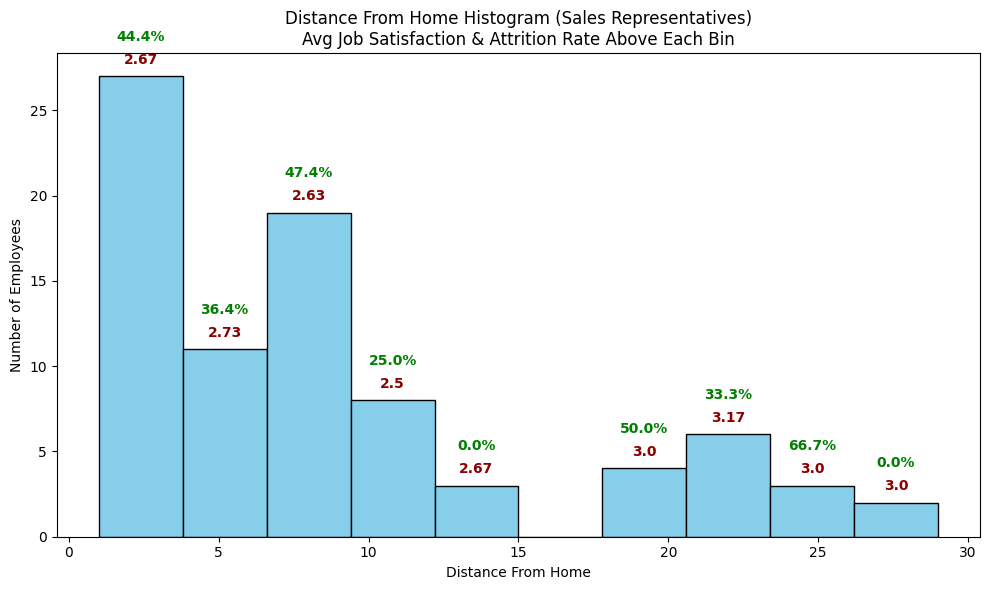

In [40]:
# adjust the graph to show only when the employees have a sales representative job role. keep this prompt as a comment on the top of the code

# Filter for Sales Representatives in Sales department
sales_rep_data = attrition_data[(attrition_data['Department'] == 'Sales') & 
                                (attrition_data['JobRole'] == 'Sales Representative')]

num_bins = 10
distances = sales_rep_data['DistanceFromHome']
bin_edges = np.histogram_bin_edges(distances, bins=num_bins)
bin_indices = np.digitize(distances, bin_edges, right=False)

def bin_stat(df, col, func, na="N/A"):
    return func(df[col]) if not df.empty and col in df and func(df[col]) is not None else na

# Only compute Job Satisfaction and Attrition Rate per bin (remove marital status)
stats = [
    (
        bin_stat(sales_rep_data[bin_indices == i], 'JobSatisfaction', lambda x: round(x.mean(), 2) if not np.isnan(x.mean()) else None),
        bin_stat(sales_rep_data[bin_indices == i], 'Attrition', lambda x: f"{100 * (x == 'Yes').mean():.1f}%" if len(x) else None)
    )
    for i in range(1, len(bin_edges))
]

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(distances, bins=bin_edges, color='skyblue', edgecolor='black')

for i, patch in enumerate(patches):
    bin_center = patch.get_x() + patch.get_width() / 2
    height = patch.get_height()
    y_offset = max(counts) * 0.02
    for val, color in zip(stats[i], ['darkred', 'green']):
        if val != "N/A":
            plt.text(bin_center, height + y_offset, f"{val}", ha='center', va='bottom', fontsize=10, fontweight='bold', color=color)
            y_offset += max(counts) * 0.05

plt.title('Distance From Home Histogram (Sales Representatives)\nAvg Job Satisfaction & Attrition Rate Above Each Bin')
plt.xlabel('Distance From Home')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()

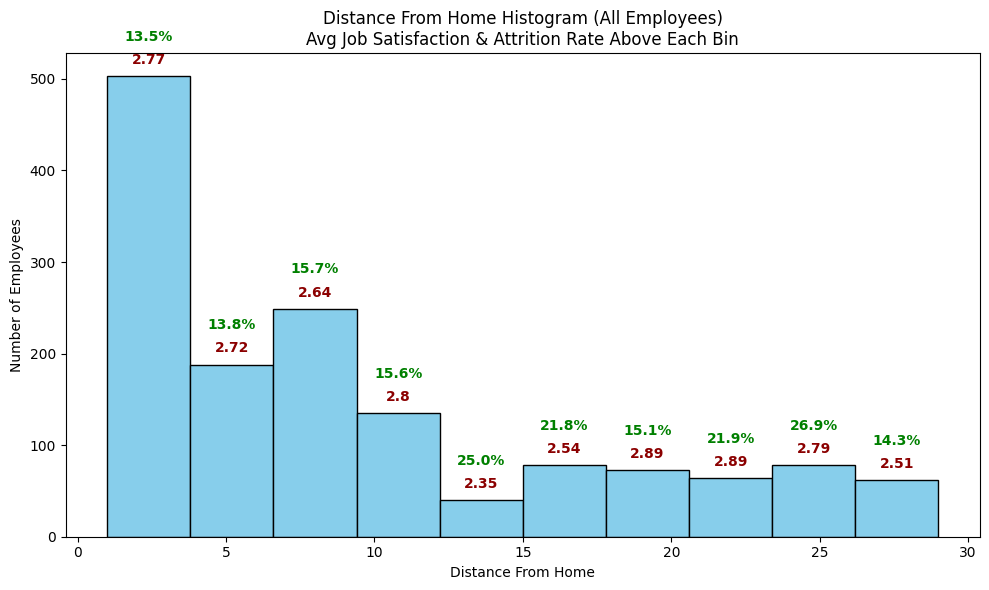

In [42]:
# Show for all company

company_data = attrition_data.copy()
num_bins = 10
distances = company_data['DistanceFromHome']
bin_edges = np.histogram_bin_edges(distances, bins=num_bins)
bin_indices = np.digitize(distances, bin_edges, right=False)

def bin_stat(df, col, func, na="N/A"):
    return func(df[col]) if not df.empty and col in df and func(df[col]) is not None else na

stats = [
    (
        bin_stat(company_data[bin_indices == i], 'JobSatisfaction', lambda x: round(x.mean(), 2) if not np.isnan(x.mean()) else None),
        bin_stat(company_data[bin_indices == i], 'Attrition', lambda x: f"{100 * (x == 'Yes').mean():.1f}%" if len(x) else None)
    )
    for i in range(1, len(bin_edges))
]

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(distances, bins=bin_edges, color='skyblue', edgecolor='black')

for i, patch in enumerate(patches):
    bin_center = patch.get_x() + patch.get_width() / 2
    height = patch.get_height()
    y_offset = max(counts) * 0.02
    for val, color in zip(stats[i], ['darkred', 'green']):
        if val != "N/A":
            plt.text(bin_center, height + y_offset, f"{val}", ha='center', va='bottom', fontsize=10, fontweight='bold', color=color)
            y_offset += max(counts) * 0.05

plt.title('Distance From Home Histogram (All Employees)\nAvg Job Satisfaction & Attrition Rate Above Each Bin')
plt.xlabel('Distance From Home')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()